# In this code a time series problem has been transformed into a supervised learning problem with velocities of 8 previous input time steps and output of 5 next time steps.
# The data of only a unique vehicle ID has been fetched and used for the model training and predictions.
# LSTM model has been trained, predictions were made over the test dataset and has been plotted against the true values.
# The entire prediction values of time t, t+1, t+2 has beem tried to compare in a plot.

In [2]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
# Using seaborn for pairplot.
!pip install -q seaborn
!pip install -q tensorflow

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print(tf.__version__)

2024-10-24 09:14:37.194204: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 09:14:37.194250: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 09:14:37.194302: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 09:14:37.206053: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [5]:
# Load the CSV file
df = pd.read_csv('../Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data_20240819.csv')

# Select the required columns
required_columns = ['Global_X', 'Global_Y', 'v_Vel', 'v_Acc', 'Global_Time', 'Vehicle_ID']
velocity_dataset = df[required_columns]

In [6]:
velocity_dataset.shape

(9455901, 6)

In [7]:
velocity_dataset.head()

,Global_X,Global_Y,v_Vel,v_Acc,Global_Time,Vehicle_ID
0,6451203.729,1873252.549,23.31,2.05,1118848075000,515
1,6451203.729,1873252.549,23.31,2.05,1118848075000,515
2,6042814.264,2133542.012,26.54,-0.76,1113437421700,2224
3,6452425.122,1872172.475,37.52,11.20,1118847624800,2127
4,6452347.673,1872258.452,41.99,0.10,1118848324700,1033


In [8]:
velocity_dataset_sorted = velocity_dataset.sort_values(by=['Vehicle_ID', 'Global_Time']).reset_index(drop=True)

In [9]:
velocity_dataset_sorted

,Global_X,Global_Y,v_Vel,v_Acc,Global_Time,Vehicle_ID
0,6042841.908,2133120.155,12.50,0.00,1113433136300,1
1,6042839.670,2133135.799,14.64,0.08,1113433137500,1
2,6042839.214,2133138.665,14.59,-0.54,1113433137700,1
3,6042838.525,2133142.971,14.13,-3.49,1113433138000,1
4,6042837.417,2133153.456,13.00,0.00,1113433138800,1
...,...,...,...,...,...,...
9455896,6042608.928,2134671.977,63.93,-11.20,1113433457400,3366
9455897,6042607.952,2134678.398,62.22,-11.20,1113433457500,3366
9455898,6042606.994,2134684.573,62.22,0.00,1113433457600,3366
9455899,6042606.083,2134690.504,62.22,0.00,1113433457700,3366


In [10]:
# Count the number of unique vehicle IDs
unique_vehicle_ids = velocity_dataset['Vehicle_ID'].nunique()
print(f"Number of unique vehicle IDs: {unique_vehicle_ids}")

# Count how many rows of data each vehicle ID has
vehicle_counts = velocity_dataset['Vehicle_ID'].value_counts()

# Display the counts of rows for each vehicle ID
print("\nNumber of rows for each vehicle ID:")
print(vehicle_counts)

Number of unique vehicle IDs: 3233

Number of rows for each vehicle ID:
396     8311
705     7508
567     7441
601     7253
468     7206
        ... 
2897     167
2806      78
2815      70
2810      66
2781      60
Name: Vehicle_ID, Length: 3233, dtype: int64


In [11]:
# Access the count for a particular vehicle ID
specific_vehicle_id = 396
num_rows = vehicle_counts[specific_vehicle_id]

print(f"The vehicle ID '{specific_vehicle_id}' has {num_rows} rows of data.")

single_vehicle_data = velocity_dataset_sorted[velocity_dataset_sorted['Vehicle_ID'] == specific_vehicle_id]

The vehicle ID '396' has 8311 rows of data.


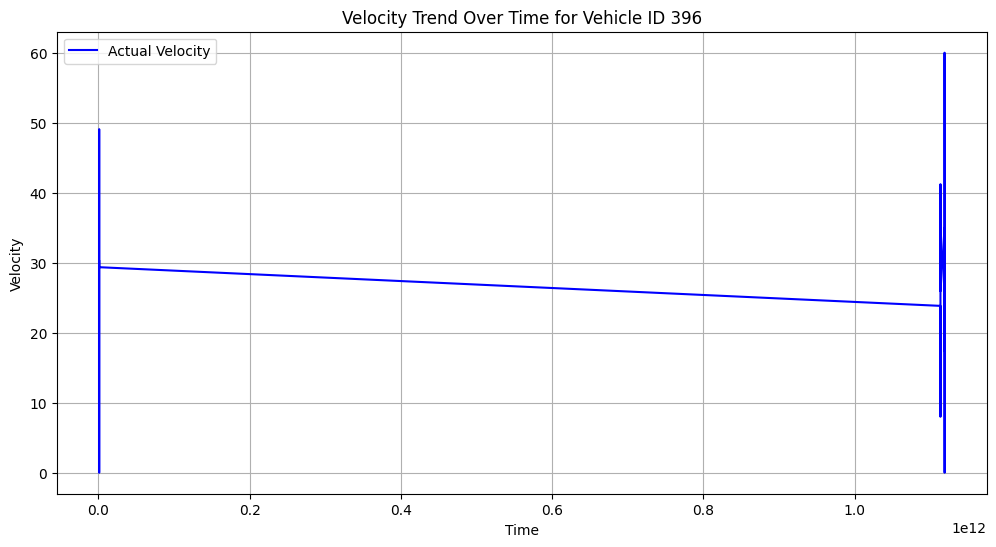

In [12]:
# Assuming 'single_vehicle_data' contains the data for a specific vehicle ID
# Extracting the time and velocity columns
time = single_vehicle_data['Global_Time'].values
velocity = single_vehicle_data['v_Vel'].values

# Plot the velocity trend over time
plt.figure(figsize=(12, 6))
plt.plot(time, velocity, label='Actual Velocity', color='blue')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity Trend Over Time for Vehicle ID {}'.format(specific_vehicle_id))
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# # Plot velocity over time
# plt.figure(figsize=(12, 6))
# plt.plot(velocity_dataset_sorted['Global_Time'], velocity_dataset_sorted['v_Vel'], label='Velocity')
# plt.xlabel('Global Time (ms)')
# plt.ylabel('Velocity (v_vel)')
# plt.title('Velocity Evolution Over Time')
# plt.legend()
# plt.grid(True)
# plt.show()

In [14]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # Ensure data is in 2D format (n_samples, n_features)
    df_s = pd.DataFrame(data)
    cols, names = [], []
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_s.shift(i))
        names += [f'var1(t-{i})']
        
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df_s.shift(-i))
        if i == 0:
            names += [f'var1(t)']
        else:
            names += [f'var1(t+{i})']
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [15]:
# Extract the velocity column
velocities = single_vehicle_data['v_Vel'].values

# Convert the velocity time series into a supervised learning problem
n_in = 8  # Number of previous time steps to use as input
n_out = 5  # Number of future time steps to predict (5 step ahead)
supervised_data = series_to_supervised(velocities, n_in=n_in, n_out=n_out)

# Time Steps:   t-8   t-7   t-6   t-5   t-4   t-3   t-2   t-1   t  t+1  t+2  t+3  t+4
# Values:      [ x ,  x ,  x ,  x ,  x ,  x ,  x ,  x ] -> [ y ,  y ,  y,  y,  y]

# Print the first few rows to verify the transformation
print(supervised_data.head())

    var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  \
8       30.25      30.25      30.25      30.25      30.25      30.25   
9       30.25      30.25      30.25      30.25      30.25      30.24   
10      30.25      30.25      30.25      30.25      30.24      30.24   
11      30.25      30.25      30.25      30.24      30.24      30.24   
12      30.25      30.25      30.24      30.24      30.24      30.24   

    var1(t-2)  var1(t-1)  var1(t)  var1(t+1)  var1(t+2)  var1(t+3)  var1(t+4)  
8       30.24      30.24    30.24      30.24      30.23      30.23      30.23  
9       30.24      30.24    30.24      30.23      30.23      30.23      30.23  
10      30.24      30.24    30.23      30.23      30.23      30.23      30.23  
11      30.24      30.23    30.23      30.23      30.23      30.23      30.23  
12      30.23      30.23    30.23      30.23      30.23      30.23      30.22  


In [16]:
# Split the supervised data into training, validation, and test sets
n_train = int(len(supervised_data) * 0.7)
n_validation = int(len(supervised_data) * 0.15)

train_data = supervised_data[:n_train]
validation_data = supervised_data[n_train:n_train + n_validation]
test_data = supervised_data[n_train + n_validation:]

# Separate inputs (X) and outputs (y)
X_train, y_train = train_data.iloc[:, :-n_out].values, train_data.iloc[:, -n_out:].values
X_validation, y_validation = validation_data.iloc[:, :-n_out].values, validation_data.iloc[:, -n_out:].values
X_test, y_test = test_data.iloc[:, :-n_out].values, test_data.iloc[:, -n_out:].values

# # Print the shapes of the splits to verify
# print("Training features shape:", X_train)
# print("Training labels shape:", y_train)
# print("Validation features shape:", X_validation)
# print("Validation labels shape:", y_validation)
# print("Test features shape:", X_test)
# print("Test labels shape:", y_test)

In [17]:
# Reshape data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], n_in, 1))
X_validation = X_validation.reshape((X_validation.shape[0], n_in, 1))
X_test = X_test.reshape((X_test.shape[0], n_in, 1))

In [18]:
print(len(y_test))
print(X_test.shape)
print(y_test.shape)

1246
(1246, 8, 1)
(1246, 5)


In [49]:
# Define the LSTM model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=False),
    tf.keras.layers.Dense(n_out)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                         validation_data=(X_validation, y_validation), 
                         verbose=1, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss = lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")

# Compute RMSE
rmse = np.sqrt(test_loss)
print(f"RMSE on the test set: {rmse:.4f}")

Epoch 1/50
182/182 [==============================] - 16s 58ms/step - loss: 130.3421 - val_loss: 14.0013
Epoch 2/50
182/182 [==============================] - 10s 57ms/step - loss: 58.4911 - val_loss: 10.3424
Epoch 3/50
182/182 [==============================] - 10s 55ms/step - loss: 55.9911 - val_loss: 8.6899
Epoch 4/50
182/182 [==============================] - 10s 54ms/step - loss: 53.9766 - val_loss: 10.4285
Epoch 5/50
182/182 [==============================] - 10s 54ms/step - loss: 53.7541 - val_loss: 16.6662
Epoch 6/50
182/182 [==============================] - 10s 53ms/step - loss: 52.9526 - val_loss: 7.8048
Epoch 7/50
182/182 [==============================] - 9s 52ms/step - loss: 52.7072 - val_loss: 9.2745
Epoch 8/50
182/182 [==============================] - 10s 54ms/step - loss: 51.9834 - val_loss: 8.9412
Epoch 9/50
182/182 [==============================] - 10s 52ms/step - loss: 51.5670 - val_loss: 8.1026
Epoch 10/50
182/182 [==============================] - 10s 52ms/step 

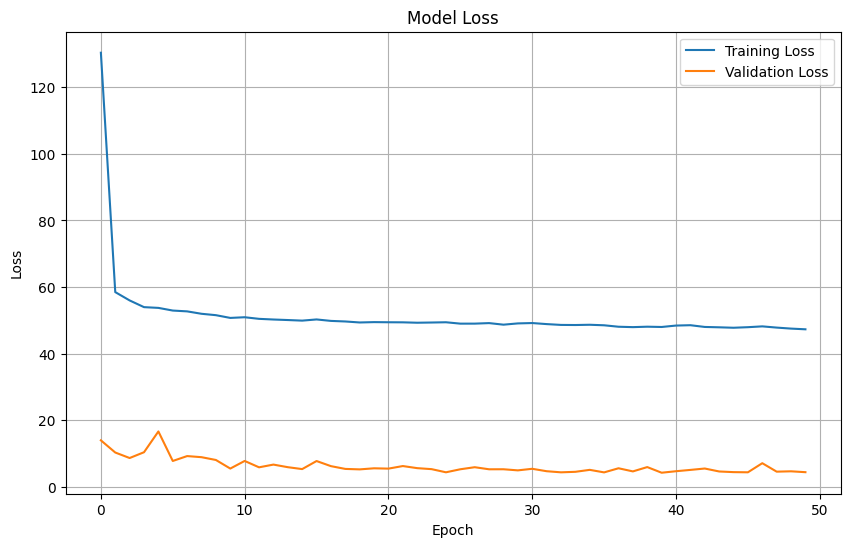

In [50]:
# Plotting training & validation loss curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history.get('val_loss'), label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [53]:
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 8, 64)             16896     
                                                                 
 lstm_57 (LSTM)              (None, 8, 64)             33024     
                                                                 
 lstm_58 (LSTM)              (None, 8, 32)             12416     
                                                                 
 lstm_59 (LSTM)              (None, 8, 32)             8320      
                                                                 
 lstm_60 (LSTM)              (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 79141 (309.14 KB)
Trainable params: 7914

In [54]:
# # Test predictions over the entire test dataset (5 output at a time)
# predictions = []

# # Loop through each sample in the test dataset
# for i in range(len(X_test)):
#     # Extract the current sequence (8 time steps)
#     current_sequence = X_test[i]  # Get the ith row
    
#     # Reshape it to the correct shape for prediction: (1, 8, 1)
#     current_sequence = current_sequence.reshape(1, current_sequence.shape[0], 1)
    
#     # Debugging print statements
#     print(f"i = {i}, current_sequence shape = {current_sequence.shape}")
    
#     # Predict the next velocity based on the current sequence
#     next_5_velocities = lstm_model.predict(current_sequence, verbose=0) # verbose=0 : Silent mode - no output during training
    
#     # Append the predicted velocity to the predictions list
#     predictions.append(next_5_velocities[0, 0])
    
#     # Shift by 5 time steps
#     i += 5

# # Print the predicted velocities for the test dataset
# print("Predicted velocities for the test dataset are:", predictions)

In [55]:
# Initialize a list to store all predictions
all_predictions = []

# Initialize the starting index
i = 0

# Loop through the test dataset, making predictions and skipping forward by 5 steps each time
while i < len(X_test):
    # Extract the current sequence from the test set (n_in time steps)
    current_sequence = X_test[i]

    # Reshape it for prediction (1 sample, n_in time steps, 1 feature)
    current_sequence = current_sequence.reshape(1, current_sequence.shape[0], 1)
        
    # Debugging print statements
    print(f"i = {i}, current_sequence shape = {current_sequence.shape}")

    # Predict the next 5 velocities based on the current sequence
    next_5_velocities = lstm_model.predict(current_sequence, verbose=0)  # Shape: (1, 5)

    # Append the 5 predicted velocities to the all_predictions list
    all_predictions.extend(next_5_velocities.flatten())  # Flatten and append

    # Skip forward by 5 time steps
    i += 5

# Print the predicted velocities for the test dataset
print("Predicted velocities for the test dataset are:", all_predictions)

i = 0, current_sequence shape = (1, 8, 1)
i = 5, current_sequence shape = (1, 8, 1)
i = 10, current_sequence shape = (1, 8, 1)
i = 15, current_sequence shape = (1, 8, 1)
i = 20, current_sequence shape = (1, 8, 1)
i = 25, current_sequence shape = (1, 8, 1)
i = 30, current_sequence shape = (1, 8, 1)
i = 35, current_sequence shape = (1, 8, 1)
i = 40, current_sequence shape = (1, 8, 1)
i = 45, current_sequence shape = (1, 8, 1)
i = 50, current_sequence shape = (1, 8, 1)
i = 55, current_sequence shape = (1, 8, 1)
i = 60, current_sequence shape = (1, 8, 1)
i = 65, current_sequence shape = (1, 8, 1)
i = 70, current_sequence shape = (1, 8, 1)
i = 75, current_sequence shape = (1, 8, 1)
i = 80, current_sequence shape = (1, 8, 1)
i = 85, current_sequence shape = (1, 8, 1)
i = 90, current_sequence shape = (1, 8, 1)
i = 95, current_sequence shape = (1, 8, 1)
i = 100, current_sequence shape = (1, 8, 1)
i = 105, current_sequence shape = (1, 8, 1)
i = 110, current_sequence shape = (1, 8, 1)
i = 115, c

i = 940, current_sequence shape = (1, 8, 1)
i = 945, current_sequence shape = (1, 8, 1)
i = 950, current_sequence shape = (1, 8, 1)
i = 955, current_sequence shape = (1, 8, 1)
i = 960, current_sequence shape = (1, 8, 1)
i = 965, current_sequence shape = (1, 8, 1)
i = 970, current_sequence shape = (1, 8, 1)
i = 975, current_sequence shape = (1, 8, 1)
i = 980, current_sequence shape = (1, 8, 1)
i = 985, current_sequence shape = (1, 8, 1)
i = 990, current_sequence shape = (1, 8, 1)
i = 995, current_sequence shape = (1, 8, 1)
i = 1000, current_sequence shape = (1, 8, 1)
i = 1005, current_sequence shape = (1, 8, 1)
i = 1010, current_sequence shape = (1, 8, 1)
i = 1015, current_sequence shape = (1, 8, 1)
i = 1020, current_sequence shape = (1, 8, 1)
i = 1025, current_sequence shape = (1, 8, 1)
i = 1030, current_sequence shape = (1, 8, 1)
i = 1035, current_sequence shape = (1, 8, 1)
i = 1040, current_sequence shape = (1, 8, 1)
i = 1045, current_sequence shape = (1, 8, 1)
i = 1050, current_sequ

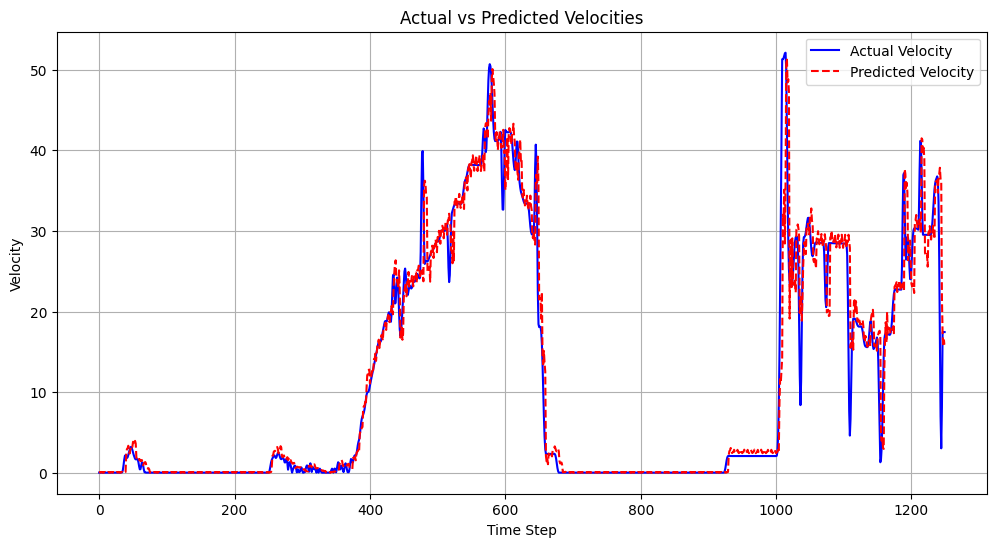

In [56]:
# Extracting the true values from the test set
true_values_to_compare = y_test[::5, :].flatten()  # Only take every 5th row, then flatten

# Plotting the actual and predicted velocities
plt.figure(figsize=(12, 6))

# Plot the actual velocities
plt.plot(np.arange(len(true_values_to_compare)), true_values_to_compare, label='Actual Velocity', color='blue')

# Plot the predicted velocities
plt.plot(np.arange(len(all_predictions)), all_predictions, label='Predicted Velocity', color='red', linestyle='--')

plt.xlabel('Time Step')
plt.ylabel('Velocity')
plt.title('Actual vs Predicted Velocities')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [57]:
true_values_df = np.array(true_values_to_compare)
predictions_values_df = np.array(all_predictions)

# Ensure both arrays have identical shapes
assert true_values_df.shape == predictions_values_df.shape, "Datasets must have the same shape!"

# Calculate RMSE using the mathematical formula
def calculate_rmse(true_values, predicted_values):
    # Calculate the mean square error
    mse = np.mean((true_values - predicted_values) ** 2)
    # Take the square root of the mean square error to get RMSE
    rmse = np.sqrt(mse)
    return rmse

# Apply RMSE calculation on all values
rmse = calculate_rmse(true_values_df, predictions_values_df)

print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 3.7330473151569


In [134]:
### ADDITIONAL LINE OF CODES ###

test_predicted_values = lstm_model.predict(X_test)

# Extract the velocity predictions for t, t+1, t+2
predicted_velocities_t = test_predicted_values[:, 0]  # Prediction at time t
predicted_velocities_t1 = test_predicted_values[:, 1]  # Prediction at time t+1
predicted_velocities_t2 = test_predicted_values[:, 2]  # Prediction at time t+2

# The true values for comparison
true_velocities_t = y_test[:, 0]  # Actual value at time t
true_velocities_t1 = y_test[:, 1]  # Actual value at time t+1
true_velocities_t2 = y_test[:, 2]  # Actual value at time t+2

rmse_t = np.sqrt(mean_squared_error(true_velocities_t, predicted_velocities_t))
rmse_t1 = np.sqrt(mean_squared_error(true_velocities_t1, predicted_velocities_t1))
rmse_t2 = np.sqrt(mean_squared_error(true_velocities_t2, predicted_velocities_t2))

print(f"RMSE at time t: {rmse_t:.4f}")
print(f"RMSE at time t+1: {rmse_t1:.4f}")
print(f"RMSE at time t+2: {rmse_t2:.4f}")

39/39 [==============================] - 0s 7ms/step
RMSE at time t: 2.2646
RMSE at time t+1: 3.0155
RMSE at time t+2: 3.8334


In [61]:
rmse_overall = np.sqrt(mean_squared_error(y_test.flatten(), test_predicted_values.flatten()))
print(f"Overall RMSE for t, t+1, t+2: {rmse_overall:.4f}")

Overall RMSE for t, t+1, t+2: 3.7597


In [62]:
# # Visualising one at a time
# # Create time indices for the test dataset
# time_indices = np.arange(len(true_velocities_t))

# # Plotting the true and predicted velocities for t, t+1, and t+2
# plt.figure(figsize=(14, 8))

# # Plot for time t
# plt.subplot(3, 1, 1)
# plt.plot(time_indices, true_velocities_t, label='True Velocity at t', color='blue')
# plt.plot(time_indices, predicted_velocities_t, label='Predicted Velocity at t', color='red', linestyle='--')
# plt.xlabel('Time')
# plt.ylabel('Velocity')
# plt.title(f'Velocity at time t (RMSE: {rmse_t:.4f})')
# plt.legend()

# # Plot for time t+1
# plt.subplot(3, 1, 2)
# plt.plot(time_indices, true_velocities_t1, label='True Velocity at t+1', color='blue')
# plt.plot(time_indices, predicted_velocities_t1, label='Predicted Velocity at t+1', color='red', linestyle='--')
# plt.xlabel('Time')
# plt.ylabel('Velocity')
# plt.title(f'Velocity at time t+1 (RMSE: {rmse_t1:.4f})')
# plt.legend()

# # Plot for time t+2
# plt.subplot(3, 1, 3)
# plt.plot(time_indices, true_velocities_t2, label='True Velocity at t+2', color='blue')
# plt.plot(time_indices, predicted_velocities_t2, label='Predicted Velocity at t+2', color='red', linestyle='--')
# plt.xlabel('Time')
# plt.ylabel('Velocity')
# plt.title(f'Velocity at time t+2 (RMSE: {rmse_t2:.4f})')
# plt.legend()

# plt.tight_layout()
# plt.show()

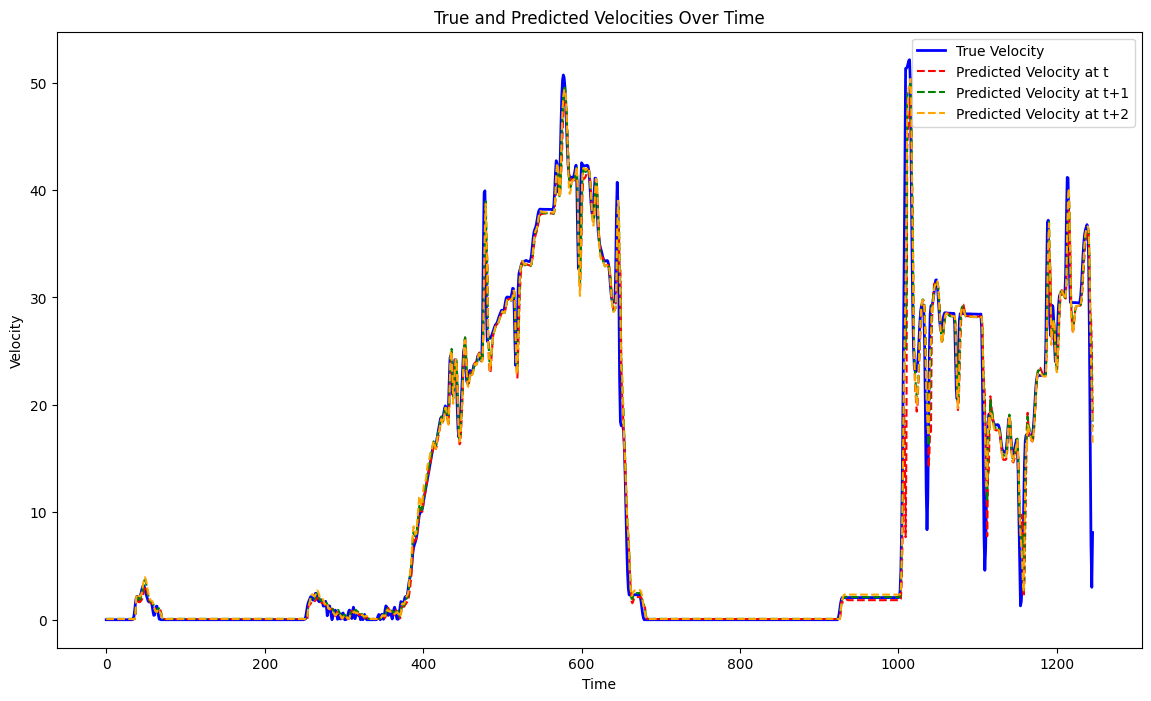

In [63]:
# Visualising all at once
# Create time indices for the test dataset
time_indices = np.arange(len(true_velocities_t))

# Plotting the true and predicted velocities
plt.figure(figsize=(14, 8))

# Plot for the true velocity at time t
plt.plot(time_indices, true_velocities_t, label='True Velocity', color='blue', linewidth=2)

# Plot for the predicted velocity at time t
plt.plot(time_indices, predicted_velocities_t, label='Predicted Velocity at t', color='red', linestyle='--')

# Plot for the predicted velocity at time t+1
plt.plot(time_indices, predicted_velocities_t1, label='Predicted Velocity at t+1', color='green', linestyle='--')

# Plot for the predicted velocity at time t+2
plt.plot(time_indices, predicted_velocities_t2, label='Predicted Velocity at t+2', color='orange', linestyle='--')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('True and Predicted Velocities Over Time')
plt.legend()

# Show plot
plt.show()

In [64]:
# Use the last known sequence from the test set for prediction
last_sequence = X_test[-1]

# Number of future steps to predict
n_steps = 6
predictions = []

for _ in range(n_steps):
    # Predict the next velocity
    next_velocity = lstm_model.predict(last_sequence.reshape(1, last_sequence.shape[0], 1), verbose=0)
    
    # Append the predicted velocity to the predictions list
    predictions.append(next_velocity[0, 0])
    
    # Update the sequence: remove the oldest velocity and add the predicted one
    last_sequence = np.append(last_sequence[1:], next_velocity[0, 0]).reshape(-1, 1)

# Print the predicted velocities for the next 6 steps
print("Predicted velocities for the next 6 time steps:", predictions)

# Convert the predictions into a DataFrame for easier handling
predicted_df = pd.DataFrame(predictions, columns=['Predicted Velocity'])

print(predicted_df)

Predicted velocities for the next 6 time steps: [19.177599, 10.791701, 12.173905, 7.880661, 7.9354377, 5.0301857]
   Predicted Velocity
0           19.177599
1           10.791701
2           12.173905
3            7.880661
4            7.935438
5            5.030186


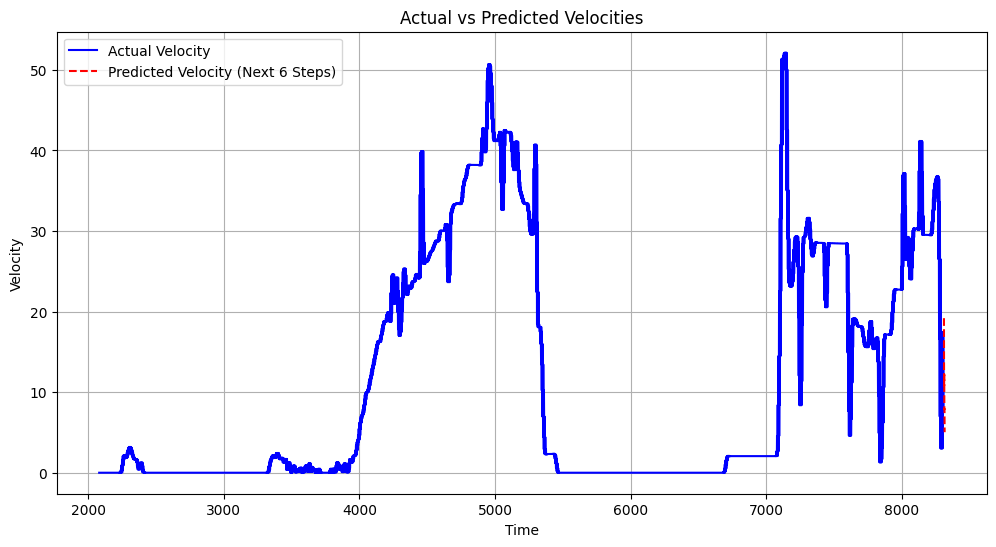

In [65]:
# Ensure the true_velocities is flattened correctly
true_velocities = y_test.flatten()

# Number of actual data points for plotting
n_true_points = len(true_velocities)

# Adjust the time indices to match the length of the true velocities
time_indices = np.arange(len(single_vehicle_data) - n_true_points, len(single_vehicle_data))

# Ensure both time_indices and true_velocities have the same length
if len(time_indices) != len(true_velocities):
    raise ValueError(f"Length of time_indices ({len(time_indices)}) does not match length of true_velocities ({len(true_velocities)}).")

# Create DataFrame for actual values (trim the time indices to match true_velocities)
actual_df = pd.DataFrame({
    'Time': time_indices,
    'Actual Velocity': true_velocities
})

# Create time indices for the predictions
predicted_time_indices = np.arange(len(single_vehicle_data), len(single_vehicle_data) + len(predictions))

# Create DataFrame for predicted values
predicted_df = pd.DataFrame({
    'Time': predicted_time_indices,
    'Predicted Velocity': predictions
})

# Plotting the actual and predicted velocities
plt.figure(figsize=(12, 6))

# Plot the actual velocities
plt.plot(actual_df['Time'], actual_df['Actual Velocity'], label='Actual Velocity', color='blue')

# Plot the predicted velocities
plt.plot(predicted_df['Time'], predicted_df['Predicted Velocity'], label='Predicted Velocity (Next 6 Steps)', color='red', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Actual vs Predicted Velocities')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()